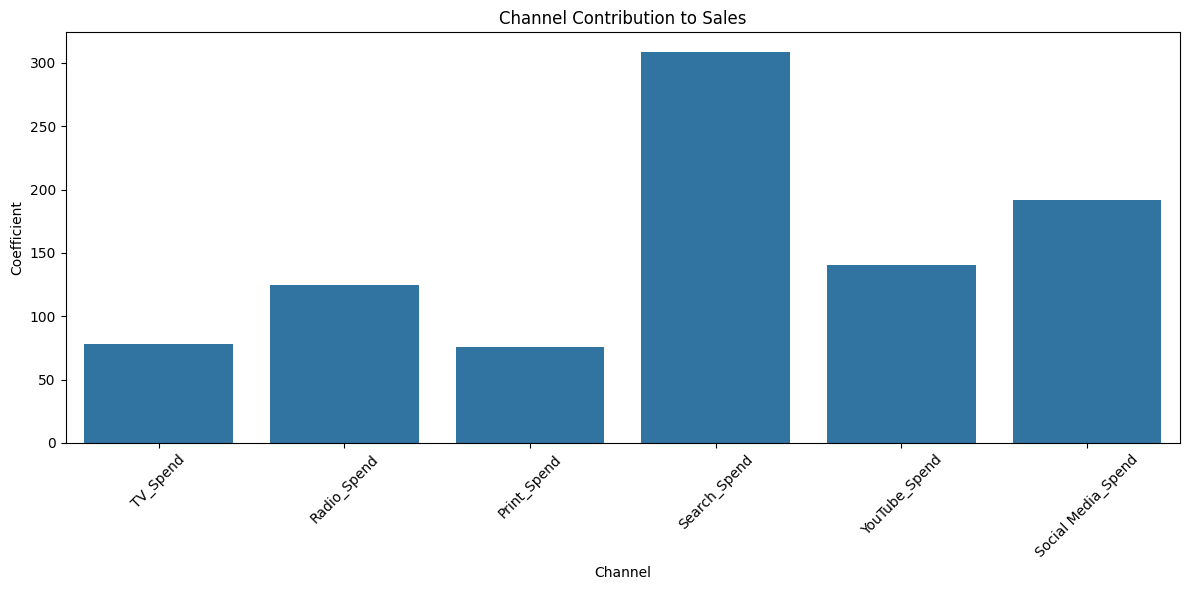

<Figure size 1500x700 with 0 Axes>

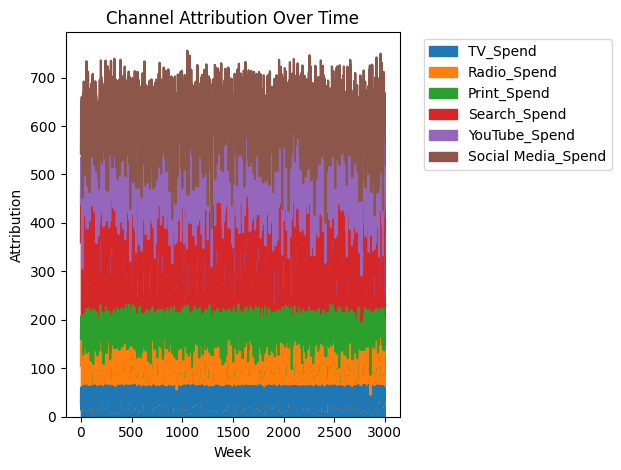

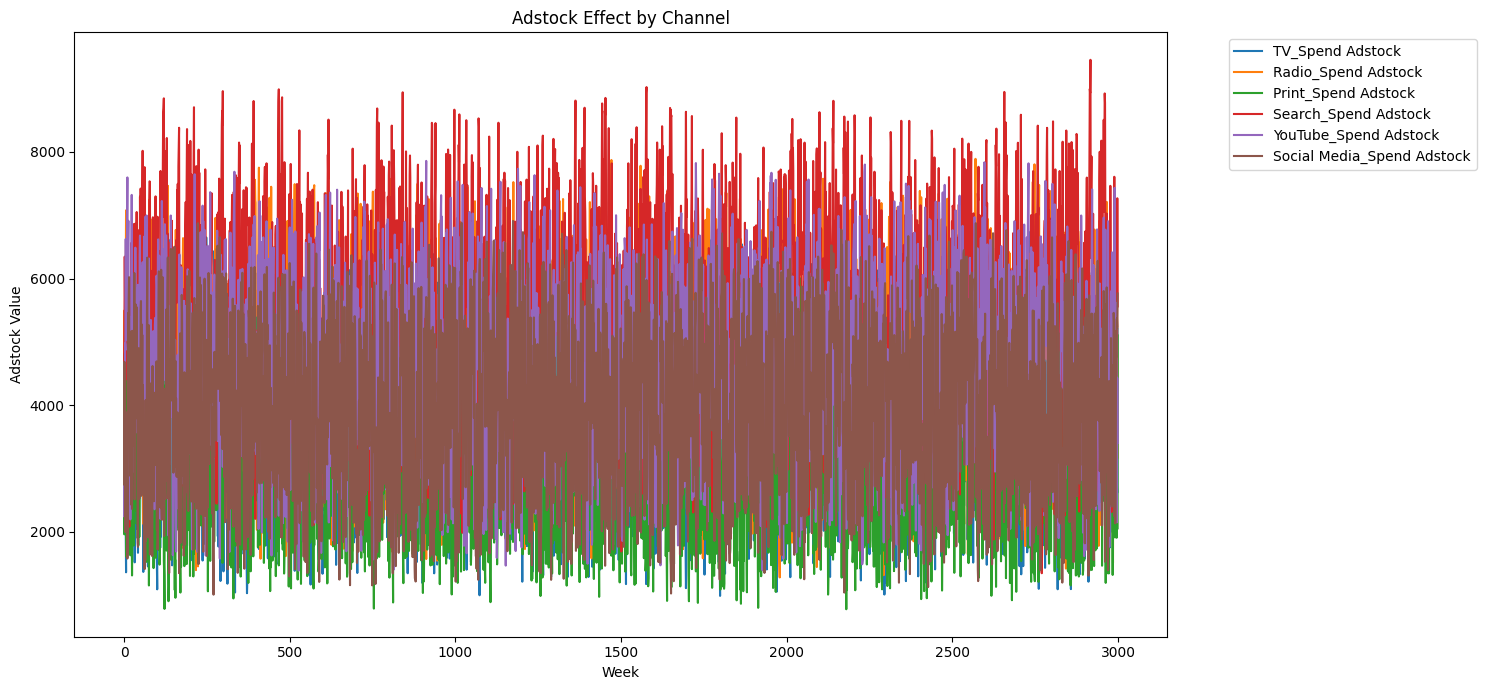

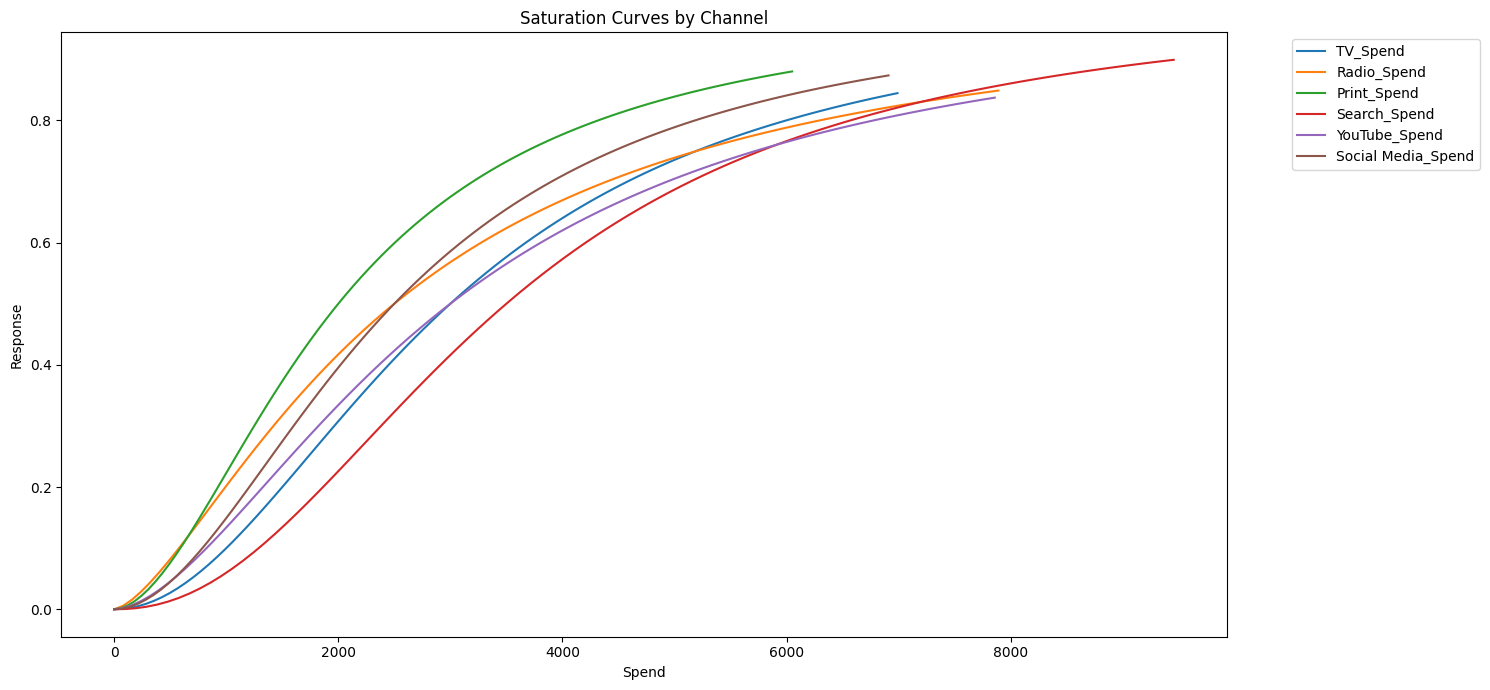


Budget Optimization Results:
              Channel  Current Allocation  Optimized Allocation    Change %
0            TV_Spend         2749.519377          7.459212e-08 -100.000000
1         Radio_Spend         2724.417289          2.252161e+03  -17.334211
2         Print_Spend         2693.264223          1.574996e+03  -41.520923
3        Search_Spend         2761.607407          5.946605e+03  115.331303
4       YouTube_Spend         2743.897970          2.889891e+03    5.320626
5  Social Media_Spend         2768.482468          3.777536e+03   36.447889


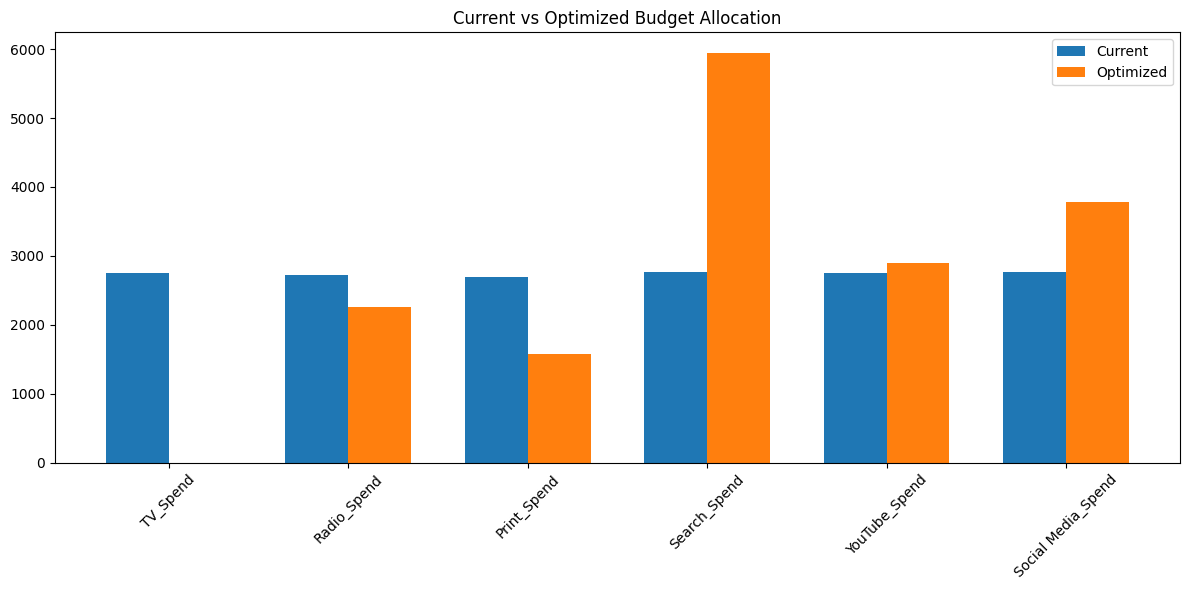

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Read the data
df = pd.read_csv('/content/MMM brand data.csv')

# Define adstock function
def adstock(x, decay_rate):
    """
    Calculate adstock values with given decay rate
    """
    adstocked = [x[0]]
    for i in range(1, len(x)):
        adstocked.append(x[i] + decay_rate * adstocked[-1])
    return np.array(adstocked)

# Define saturation function (Hill function)
def hill_transform(x, ec50, slope):
    """
    Apply Hill transformation for saturation effect
    """
    return 1 / (1 + (x / ec50) ** (-slope))

# Apply transformations to media channels
media_channels = ['TV_Spend', 'Radio_Spend', 'Print_Spend', 'Search_Spend',
                 'YouTube_Spend', 'Social Media_Spend']

# Parameters for adstock and saturation (these can be optimized)
decay_rates = {
    'TV_Spend': 0.3,
    'Radio_Spend': 0.4,
    'Print_Spend': 0.2,
    'Search_Spend': 0.5,
    'YouTube_Spend': 0.4,
    'Social Media_Spend': 0.3
}

ec50_values = {
    'TV_Spend': 3000,
    'Radio_Spend': 2500,
    'Print_Spend': 2000,
    'Search_Spend': 3500,
    'YouTube_Spend': 3000,
    'Social Media_Spend': 2500
}

slope_values = {
    'TV_Spend': 2.0,
    'Radio_Spend': 1.5,
    'Print_Spend': 1.8,
    'Search_Spend': 2.2,
    'YouTube_Spend': 1.7,
    'Social Media_Spend': 1.9
}

# Apply transformations
transformed_df = df.copy()
for channel in media_channels:
    # Apply adstock
    transformed_df[f'{channel}_adstock'] = adstock(df[channel].values, decay_rates[channel])

    # Apply saturation
    transformed_df[f'{channel}_final'] = hill_transform(
        transformed_df[f'{channel}_adstock'],
        ec50_values[channel],
        slope_values[channel]
    )

# Build regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare features and target
X = transformed_df[[f'{channel}_final' for channel in media_channels]]
y = transformed_df['Sales']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Get coefficients
coefficients = pd.DataFrame({
    'Channel': media_channels,
    'Coefficient': model.coef_
})

# Calculate attribution
def calculate_attribution(row, coefficients):
    attribution = {}
    for channel, coef in zip(media_channels, coefficients):
        attribution[channel] = row[f'{channel}_final'] * coef
    return attribution

# Calculate attribution for each week
weekly_attribution = transformed_df.apply(
    lambda row: calculate_attribution(row, model.coef_),
    axis=1
)

# Convert to DataFrame
attribution_df = pd.DataFrame(weekly_attribution.tolist())

# Plotting functions
def plot_channel_contribution():
    plt.figure(figsize=(12, 6))
    sns.barplot(data=coefficients, x='Channel', y='Coefficient')
    plt.xticks(rotation=45)
    plt.title('Channel Contribution to Sales')
    plt.tight_layout()
    plt.show()

def plot_attribution_over_time():
    plt.figure(figsize=(15, 7))
    attribution_df.plot(kind='area', stacked=True)
    plt.title('Channel Attribution Over Time')
    plt.xlabel('Week')
    plt.ylabel('Attribution')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_adstock_effect():
    plt.figure(figsize=(15, 7))
    for channel in media_channels:
        plt.plot(transformed_df[f'{channel}_adstock'],
                label=f'{channel} Adstock')
    plt.title('Adstock Effect by Channel')
    plt.xlabel('Week')
    plt.ylabel('Adstock Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_saturation_curves():
    plt.figure(figsize=(15, 7))
    for channel in media_channels:
        x = np.linspace(0, max(transformed_df[f'{channel}_adstock']), 100)
        y = hill_transform(x, ec50_values[channel], slope_values[channel])
        plt.plot(x, y, label=channel)
    plt.title('Saturation Curves by Channel')
    plt.xlabel('Spend')
    plt.ylabel('Response')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot all visualizations
plot_channel_contribution()
plot_attribution_over_time()
plot_adstock_effect()
plot_saturation_curves()

# Optimization function
def optimize_budget(total_budget, current_allocation):
    """
    Optimize budget allocation based on model coefficients
    """
    constraints = [
        {'type': 'eq', 'fun': lambda x: sum(x) - total_budget},  # Budget constraint
        {'type': 'ineq', 'fun': lambda x: x}  # Non-negative constraint
    ]

    def objective(x):
        # Transform spends using adstock and saturation
        transformed_spends = []
        for i, spend in enumerate(x):
            adstocked = adstock(np.array([spend]), decay_rates[media_channels[i]])[0]
            saturated = hill_transform(adstocked,
                                    ec50_values[media_channels[i]],
                                    slope_values[media_channels[i]])
            transformed_spends.append(saturated)

        # Calculate predicted sales
        return -sum(coef * spend for coef, spend in zip(model.coef_, transformed_spends))

    result = minimize(objective,
                     current_allocation,
                     constraints=constraints,
                     method='SLSQP')

    return result.x

# Calculate current total budget and optimize
current_allocation = df[media_channels].mean().values
total_budget = sum(current_allocation)
optimized_allocation = optimize_budget(total_budget, current_allocation)

# Compare pre and post optimization
comparison = pd.DataFrame({
    'Channel': media_channels,
    'Current Allocation': current_allocation,
    'Optimized Allocation': optimized_allocation,
    'Change %': (optimized_allocation - current_allocation) / current_allocation * 100
})

print("\nBudget Optimization Results:")
print(comparison)

# Plot optimization comparison
plt.figure(figsize=(12, 6))
width = 0.35
x = np.arange(len(media_channels))
plt.bar(x - width/2, current_allocation, width, label='Current')
plt.bar(x + width/2, optimized_allocation, width, label='Optimized')
plt.xticks(x, media_channels, rotation=45)
plt.title('Current vs Optimized Budget Allocation')
plt.legend()
plt.tight_layout()
plt.show()